[← Previous: Topic Modeling with NMF ](03_topic_modeling_byNMF.ipynb)
# **Unsupervised Topic Modeling with BERTopic**

**Goal:** Using BERTopic model to discover topic in general Reddit communities.

---

## Table of Contents

- [1. Imports & Environment Settings](#1-imports--environment-settings)
- [2. Helper Functions](#2-helper-functions)
- [3. Data Ingestion & Preprocessing](#3-data-ingestion--preprocessing)
- [4. Comparing Text Processing Methods](#4-comparing-text-processing-methods)
- [5. Comparing Different Parameter Sets](#5-comparing-different-parameter-sets)
- [6. Final Model Fitting and Output](#6-final-model-fitting--output)
- [6. Word Could and Topic Distribution](#7-word-could-and-topic-distribution)

[Next: Labeled Dataset Comparison →](05_dataset_comparison_analysis.ipynb)


### **Executive Summary**

**Topic Modeling Performance**
- **Final Model**: 7 distinct topics
- **Metrics**: coherence value = 0.730, outlier fraction = 0.049, topic diversity = 97.1%

**Key Findings**
- **Overlapping themes**: Topics 0, −1, and 2 share several high-frequency words (onli, better, good), indicating they likely represent overlapping or fragmented aspects of a broader theme.
- **Distinct clusters**: The other topics are more distinguishable, capturing unique discussions or perspectives.
- **Topic dominance**: Topic 0 appears across nearly all subreddits and represents a large portion of posts, likely due to subreddit selection bias (overrepresentation of anxiety-related communities) rather than a modeling issue.
- **Model validity**: The economy topic’s clear focus on Trump-market discussions shows the model can successfully separate distinct themes, supporting the interpretation that Topic 0’s size reflects dataset bias rather than poor model performance.

**Limitations**
- Our subreddit selection may introduce bias, causing the anxiety-related topic to be more widely distributed across different subreddits.
- Overly aggressive text preprocessing could remove too many words, leaving similar terms in the documents and resulting in narrowly defined clusters.
- BERTopic may cluster unrelated posts together or mark them as outliers. The model can also struggle with short texts due to insufficient context for embeddings to capture meaningful themes.
- There is a trade-off between coherence, coverage, and the number of topics. To achieve higher coherence and better coverage, we reduced the number of topics. This could potentially be improved through more parameter testing, but due to time constraints, we will stop here for now.

**Output Artifacts**
- Annotated DataFrame (`data/processed/reddit_topics_by_bertopic.parquet`)

Ready for downstream analysis using supervised learning methods.

In [ ]:
# %pip install -r ../requirements.txt
# %pip install --upgrade --force-reinstall "transformers==4.57.0"
# %pip install --upgrade --force-reinstall "numpy==1.26.4" "scipy==1.11.4"

  Using cached transformers-4.57.0-py3-none-any.whl.metadata (41 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.35.3-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-2.3.3-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.4 kB)
  Using cached regex-2025.9.18-cp312-cp312-macosx_11_0_arm64.whl.metadata (40 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.8 kB)
  Using cached safetensors-0.6.2-cp38-abi3-macosx_11_0_arm64.whl.metadata (4.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached hf_xet-1.1.10-cp37-abi3-macosx_11_0_arm6

## **1. Imports & Environment Settings**

**Purpose**: Initialize required libraries, set reproducible seeds and environment.

In [2]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from pathlib import Path
import sys
sys.path.append("../src") 

import text_processing_functions as tp
from typing import Sequence, Dict, Any, Tuple, List
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import time

import matplotlib.pyplot as plt
from wordcloud import WordCloud


from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer 
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP

# set environment variable to avoid tokenizer parallelism warnings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
import torch
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


## **2. Helper Functions**

**Purpose**: Provides utilities for text processing and model evaluation.

In [3]:
def text_process_with_light_stop_words(texts):
    """
    Generate tokens that applied light cutomized stop words for text processing method testing
    """
    stop_words_light = {'<cmt>', '[deleted]', 'amp', 'http', 'https', 'edit',
                'deleted', 'thing', 'stuff', 'really', 'just', 'like',
                'thanks', 'lol', 'im', 'dont', 'ive', 'youre', 'thats'}
    tokens = [
        w
        for w in texts
        if w not in stop_words_light
        and len(w) > 1
        and " " not in w
    ]
    return tokens

def evaluate_bertopic(
    model: BERTopic,
    docs_tokens: Sequence[Sequence[str]],
    doc_topics: Sequence[int],
    *,
    top_n_words: int = 10,
) -> Dict[str, Any]:
    """
    Compute BERTopic evaluation metrics:
      • Topic Coherence (c_v) using gensim.
      • Outlier fraction (topic == -1).
      • Topic diversity (share of unique top words).

    Parameters
    ----------
    model :
        Fitted BERTopic instance.
    docs_tokens :
        Tokenized documents used to fit/evaluate the model.
    doc_topics :
        Topic assignment per document (the `topics` output from fit_transform).
    top_n_words :
        Number of top terms per topic to use for coherence and diversity.

    Returns
    -------
    dict with keys:
        'coherence_cv' (float),
        'outlier_fraction' (float),
        'topic_diversity' (float)
    """
    # Build gensim dictionary/corpus for coherence
    dictionary = Dictionary(docs_tokens)
    corpus = [dictionary.doc2bow(doc) for doc in docs_tokens]

    # Collect top words per topic (skip the outlier topic -1)
    topic_words: List[List[str]] = []
    topics_dict = model.get_topics()
    for topic_id in model.get_topic_info()["Topic"]:
        if topic_id == -1:
            continue
        words = [word for word, _ in topics_dict[topic_id][:top_n_words]]
        topic_words.append(words)

    # Coherence (c_v)
    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=docs_tokens,
        corpus=corpus,
        dictionary=dictionary,
        coherence="c_v",
    )
    coherence_cv = coherence_model.get_coherence()

    # Outlier fraction
    doc_topics_arr = np.asarray(doc_topics)
    outlier_fraction = float(np.mean(doc_topics_arr == -1))

    # Topic diversity: unique words divided by total words considered
    unique_words = len({word for words in topic_words for word in words})
    total_words = len(topic_words) * top_n_words
    topic_diversity = unique_words / total_words if total_words else float("nan")
    n_topics = model.get_topic_freq().query("Topic != -1").shape[0]


    return {
        "coherence_cv": coherence_cv,
        "outlier_fraction": outlier_fraction,
        "topic_diversity": topic_diversity,
        "n_topics": n_topics
    }

## **3. Data Ingestion & Preprocessing**

**Purpose**: Load the Reddit dataset, generate stop words and apply process text function imported from `src/text_processing_functions.py` to process Reddit posts.

- Create a copy of the raw dataset.
- Posts processed with the default stop_words saved as `text_all_processed`
- Posts processed with TF-IDF-based stop words are saved as `text_all_processed_tfidf`
- Posts processed with lightly customized stop words are saved as `text_all_processed_light`

In [4]:
path = Path("../data/processed/reddit_anxiety_v1.parquet")
raw_data = pd.read_parquet(path)

# Generate two sets of stopwords: base + auto-detected
print("Generating stopwords...")
_, stopwords = tp.process_text(
    "\n\n".join(raw_data["text_all"].astype(str)),
    return_stopwords=True,
)

_, auto_stop, stopwords_tfidf = tp.process_text_tfidf(
    "\n\n".join(raw_data["text_all"].astype(str)),
    return_stopwords=True,
)

start_time = time.time()
print("Preprocessing text...")
df = raw_data.copy()

df["text_all_processed"] = (
    df["text_all"]
    .fillna("")
    .apply(lambda doc: tp.process_text(doc, extra_stopwords=stopwords))
)
df["text_all_processed_tfidf"] = (
    df["text_all"]
    .fillna("")
    .apply(lambda doc: tp.process_text_tfidf(doc, extra_stopwords=stopwords_tfidf)) # identified a problem
)

df["text_all_processed_light"] = (
    df["text_all"]
    .fillna("")
    .apply(lambda doc: text_process_with_light_stop_words(doc.split())) )

print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
print(f"Loaded {len(df):,} submissions")
print(df['subreddit'].value_counts())
df.head(5)

Generating stopwords...
Preprocessing text...
Data preprocessing time: 76.89 seconds
Loaded 6,283 submissions
subreddit
unpopularopinion    976
Anxiety             968
TrueOffMyChest      914
economy             893
mentalhealth        788
OpenAI              768
GetMotivated        678
HealthAnxiety       298
Name: count, dtype: int64


,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,removed_by_category,...,title_clean,selftext_clean,comments_concat,comment_count,text_main,text_all,comments_missing,text_all_processed,text_all_processed_tfidf,text_all_processed_light
0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,<NA>,...,how do you calm your mind during health anxiet...,i’ve been struggling with health anxiety latel...,i try to think back on all the times i've spir...,3,how do you calm your mind during health anxiet...,how do you calm your mind during health anxiet...,0,"[calm, mind, dure, health, anxieti, spiral, st...","[dure, anxieti, struggl, anxieti, worst-cas, e...","[how, do, you, calm, your, mind, during, healt..."
1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,<NA>,...,exposure therapy,has anyone managed to overcome health anxiety ...,starting it now! just made a fear ladder with ...,3,exposure therapy\n\nhas anyone managed to over...,exposure therapy\n\nhas anyone managed to over...,0,"[exposur, therapi, manag, overcom, health, anx...","[exposur, therapi, manag, overcom, anxieti, on...","[exposure, therapy, has, anyone, managed, to, ..."
2,1frykue,HealthAnxiety,1727593277,embarrassed to seek medical attention?,"Hi, i wanted to ask if anyone else feels sympt...",68,25,1.00,False,<NA>,...,embarrassed to seek medical attention?,"hi, i wanted to ask if anyone else feels sympt...",i always tell my doctor that i struggle with a...,3,"embarrassed to seek medical attention?\n\nhi, ...","embarrassed to seek medical attention?\n\nhi, ...",0,"[embarrass, seek, medic, attent, hi, els, symp...","[embarrass, medic, attent, els, struggl, sched...","[embarrassed, to, seek, medical, attention?, h..."
3,1fso9mv,HealthAnxiety,1727674066,"When you feel most bodily anxious, what works ...",I have a lot of bodily anxieties and am so afr...,31,60,0.98,False,<NA>,...,"when you feel most bodily anxious, what works ...",i have a lot of bodily anxieties and am so afr...,"this is embarrassing to admit, but i carry aro...",3,"when you feel most bodily anxious, what works ...","when you feel most bodily anxious, what works ...",0,"[bodili, anxious, semi, consist, lot, bodili, ...","[bodili, semi, consist, bodili, anxieti, bodi,...","[when, you, feel, most, bodily, anxious,, what..."
4,1ftczi7,HealthAnxiety,1727748023,Daily Positivity & HA Journey Progress Updates...,"**The megathread for vents, rants, worries, fi...",1,22,1.00,False,<NA>,...,daily positivity & ha journey progress updates...,"**the megathread for vents, rants, worries, fi...",despite being on edge all weekend knowing my b...,3,daily positivity & ha journey progress updates...,daily positivity & ha journey progress updates...,0,"[daili, posit, ha, journey, progress, updat, m...","[daili, posit, updat, octob, worri, fixat, dae...","[daily, positivity, ha, journey, progress, upd..."


## **4. Comparing Text Processing Methods**

**Purpose**: Compare four different text processing methods using coherence, outlier fraction, topic diversity, and the number of topics as evaluation metrics to select the method that offers the best performance.

In [5]:
# comparing different text processing methods
start_time = time.time()

comparing_dict = {
    "not using Text Processing": df["text_all"].fillna("").astype(str).tolist(),
    "using Light Stop Words": df["text_all_processed_light"].apply(lambda toks: " ".join(toks)).tolist(),
    "using Text Processing": df["text_all_processed"].apply(lambda toks: " ".join(toks)).tolist(),
    "using Text Processing with TF-IDF": df["text_all_processed_tfidf"].apply(lambda toks: " ".join(toks)).tolist(),
}
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") 
text_process_compare = pd.DataFrame.from_dict(comparing_dict)
metrics_list = []
for desc, docs in comparing_dict.items():
    print(f"--- Processing {desc} ---")
    topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=UMAP(random_state=42),
    hdbscan_model=HDBSCAN(min_cluster_size=15),
    vectorizer_model=CountVectorizer(),
    ctfidf_model=ClassTfidfTransformer()
    )
    topics, probs = topic_model.fit_transform(docs)
    docs_tokens = [doc.split() for doc in docs]    
    metrics = evaluate_bertopic(topic_model, docs_tokens, topics, top_n_words=10)
    metrics_list.append((desc, metrics))

metrics_df = pd.DataFrame(
    [ {"description": desc, **metrics} for desc, metrics in metrics_list ]
)
print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
metrics_df

--- Processing not using Text Processing ---


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


--- Processing using Light Stop Words ---
--- Processing using Text Processing ---
--- Processing using Text Processing with TF-IDF ---
Data preprocessing time: 475.64 seconds


,description,coherence_cv,outlier_fraction,topic_diversity,n_topics
0,not using Text Processing,0.465186,0.135763,0.496296,27
1,using Light Stop Words,0.478961,0.129078,0.575862,29
2,using Text Processing,0.588065,0.319115,0.850000,30
3,using Text Processing with TF-IDF,0.767912,0.000000,0.600000,2


### Comparing 4 text preprocessing methods for BERTopic
**Metrics Explanation**
- **coherence_cv**: Measuring how well the top words in each topic "make sense together". Higher the value means more meaningful topics.
- **outlier_fraction**: Measuring the percentage of posts that didn't fit into any topic (HDBSCAN marked them as -1). Lower the value means better coverage.
- **topic_diversity**: Measuing how distinct the top topic words are from each other (less duplication). Higher the value means broader, less repetitive topics.

**Not using Text Process**
- Topics read loosely (coherence ≈0.47); 14% of posts fall outside any topic; topics reuse many of the same words (diversity ≈0.50); 27 topics total.

**Using Light Stop Words**
- Small coherence bump (≈0.48) and slightly fewer outliers (13%); topics are a bit more distinct (diversity ≈0.58); 29 topics.

**Using Text Process**
- Topics are much clearer (coherence ≈0.59) and vocabulary is varied (diversity ≈0.85) with 30 topics, but almost one‑third of documents don’t land in a topic (outlier_fraction ≈0.32).
- ✅ Recommended as baseline for improvement

**Using Text Processing with TF-IDF**
- Keeps every document in a topic (outlier_fraction = 0) with highest coherence value (0.77), however the model collapses to only 2 topics.


### Conclusion
- Using **Text Processing** as baseline: It gives thestrong coherence and plenty of distinct topics (≈30). To tackle the higher outlier rate, tune the clustering later—relax HDBSCAN slightly or filter short/noisy docs—while keeping this richer preprocessing pipeline in place.

## **5. Comparing Different Parameter Sets**

**Purpose**: Compare five parameter sets using coherence, outlier fraction, topic diversity, and the number of topics as evaluation metrics to select the set that offers the best performance.

In [6]:
# comparing different parameters for BERTopic
start_time = time.time()
param_sets = [
    { 
        "name": "baseline_improvement",
        "umap_model": UMAP(n_neighbors=25, min_dist=0.1, random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=15, min_samples=12, prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95),
        "ctfidf_model": ClassTfidfTransformer(),
        "top_n_words": 10
    },
    {
        "name": "balanced_baseline",
        "umap_model": UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=20, min_samples=10, cluster_selection_method="leaf", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=2, max_df=0.95,
        stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(reduce_frequent_words=True),
        "top_n_words": 15
    },
    {
        "name": "coherence_focused",
        "umap_model": UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=25, min_samples=25, cluster_selection_epsilon=0.1, cluster_selection_method="eom", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 3), min_df=0.02,max_df=0.9,         max_features=20000, stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(reduce_frequent_words=False),
        "top_n_words": 20
    },
    {
        "name": "diversity_focused",
        "umap_model": UMAP(n_neighbors=10, n_components=7, min_dist=0.1, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=10, min_samples=5, cluster_selection_method="eom", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.98, max_features=5000,stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(
            reduce_frequent_words=True,
            bm25_weighting=True,
        ),
        "top_n_words": 10,
    },
    {
        "name": "low_outlier",
        "umap_model": UMAP(n_neighbors=50, n_components=5, min_dist=0.0, metric="cosine", random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=30, min_samples=None, cluster_selection_method="leaf", prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.85, stop_words=None),
        "ctfidf_model": ClassTfidfTransformer(),
        "top_n_words": 10
    },

]

docs = df["text_all_processed"].apply(lambda toks: " ".join(toks)).tolist()

embeddings = embedding_model.encode(
    docs,
    convert_to_numpy=True,
    show_progress_bar=True,
    batch_size=32,
)

results = []

for params in param_sets:
    print(f"--- Processing {params['name']} ---")
    topic_model = BERTopic(
        embedding_model=embedding_model, 
        umap_model=params["umap_model"],
        hdbscan_model=params["hdbscan_model"],
        vectorizer_model=params["vectorizer_model"],
        ctfidf_model=params["ctfidf_model"],
        top_n_words=params["top_n_words"],
    )
    topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
    docs_tokens = [doc.split() for doc in docs]    
    metrics = evaluate_bertopic(topic_model, docs_tokens, topics, top_n_words=params["top_n_words"])
    results.append({"name": params["name"], **metrics})


results_df = pd.DataFrame(results)
print(f"Data preprocessing time: {time.time() - start_time:.2f} seconds")
results_df

Batches:   0%|          | 0/197 [00:00<?, ?it/s]

--- Processing baseline_improvement ---
--- Processing balanced_baseline ---
--- Processing coherence_focused ---
--- Processing diversity_focused ---
--- Processing low_outlier ---
Data preprocessing time: 197.59 seconds


,name,coherence_cv,outlier_fraction,topic_diversity,n_topics
0,baseline_improvement,0.729794,0.049499,0.971429,7
1,balanced_baseline,0.525056,0.557536,0.941026,52
2,coherence_focused,0.452864,0.001592,1.000000,2
3,diversity_focused,0.485257,0.472863,0.878218,101
4,low_outlier,0.666536,0.664491,0.895000,20


### Comparing 5 parameter sets for BERTopic
**Baseline Improvement**
- Topics read very clearly (coherence ≈0.73), almost every post is assigned to a topic (outliers ≈5%), and topics use very different vocabularies (diversity ≈0.97), but the model finds only 7 topics in total.
- ✅ Recommended as optimal parameter set for now.

**Balanced Baseline**
- Topics are moderately coherent (≈0.53), yet over half of the documents were left unassigned (outliers ≈56%); diversity stays high (≈0.94) and we get 52 topics.

**Coherence Focused**
- Coherence actually drops (≈0.45). Outliers are near zero (0.16%), and topics never reuse words (diversity = 1.0), but there are only 2 topics—too few for most analyses.

**Diversity Focused**
- Topics overlap more on wording (diversity ≈0.88) and coherence is low (≈0.49); nearly half the documents sit outside all topics (outliers ≈47%), though we can get many topics (101).

**Low Outlier**
- Topic descriptions look good (coherence ≈0.67), but 66% of documents are still marked as outliers; vocabulary stays fairly distinct (≈0.90) with 20 topics.

### Conclusion
- We are targeting high coherence value, low outlier fraction, high topic diversity and more distinct number of topics. however, none of these parameter sets hits every target at once. Only **baseline_improvement** clears the coherence ≥0.6 bar while also keeping outliers low (≈5%) and diversity high (≈0.97), but it collapses to just 7 topics. **low_outlier** has acceptable coherence, yet more than 66% of documents are flagged as outliers, so it doesn’t meet the “lower outlier” requirement. Given that, **baseline_improvement** gives the best performance, hence recommend to use the parameter set of **baseline_improvement**.

## **6. Final Model Fitting & Output**

**Purpose**: Fit BERTopic model using optimized parameters, and output topic data table.

In [7]:
best_params = { 
        "name": "baseline_improvement",
        "umap_model": UMAP(n_neighbors=25, min_dist=0.1, random_state=42),
        "hdbscan_model": HDBSCAN(min_cluster_size=15, min_samples=12, prediction_data=True),
        "vectorizer_model": CountVectorizer(ngram_range=(1, 2), min_df=1, max_df=0.95),
        "ctfidf_model": ClassTfidfTransformer(),
        "top_n_words": 10
    }

topic_model = BERTopic(
    embedding_model=embedding_model, 
    umap_model=best_params["umap_model"],
    hdbscan_model=best_params["hdbscan_model"],
    vectorizer_model=best_params["vectorizer_model"],
    ctfidf_model=best_params["ctfidf_model"],
    top_n_words=best_params["top_n_words"],
)
topics, probs = topic_model.fit_transform(docs, embeddings=embeddings)
bertopic_df = topic_model.get_document_info(docs)
bertopic_df.head(5)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,calm mind dure health anxieti spiral struggl h...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
1,exposur therapi manag overcom health anxieti o...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
2,embarrass seek medic attent hi els symptom str...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
3,bodili anxious semi consist lot bodili anxieti...,0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
4,daili posit ha journey progress updat megathre...,-1,-1_life_job_posit_anxieti,"[life, job, posit, anxieti, thought, live, ple...",[daili posit ha journey progress updat megathr...,life - job - posit - anxieti - thought - live ...,0.0,False


In [8]:
# Merge topic data with original dataframe and save to parquet
bertopic_df['doc_ids'] = df.index
merged = df.reset_index()
merged = merged.merge(bertopic_df, how = 'left', left_on = 'index', right_on = 'doc_ids')
merged.drop(columns=['text_all_processed_tfidf', 'text_all_processed_light', 'Document', 'doc_ids'], inplace=True)
merged.to_parquet("../data/processed/reddit_topics_by_bertopic.parquet", index=False)
merged.head(2)


,index,post_id,subreddit,created_ts,title,selftext,score,num_comments,upvote_ratio,over_18,...,text_all,comments_missing,text_all_processed,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,0,1fqk5d2,HealthAnxiety,1727431124,How Do You Calm Your Mind During Health Anxiet...,I’ve been struggling with health anxiety latel...,79,63,0.98,False,...,how do you calm your mind during health anxiet...,0,"[calm, mind, dure, health, anxieti, spiral, st...",0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False
1,1,1fryfai,HealthAnxiety,1727592641,Exposure therapy,Has anyone managed to overcome health anxiety ...,12,12,0.94,False,...,exposure therapy\n\nhas anyone managed to over...,0,"[exposur, therapi, manag, overcom, health, anx...",0,0_anxieti_life_friend_good,"[anxieti, life, friend, good, love, thought, e...",[discuss stay motiv hi everyon motiv struggl l...,anxieti - life - friend - good - love - though...,1.0,False


## **7. Word Could and Topic Distribution**

**Purpose**: Check the topic patterns.

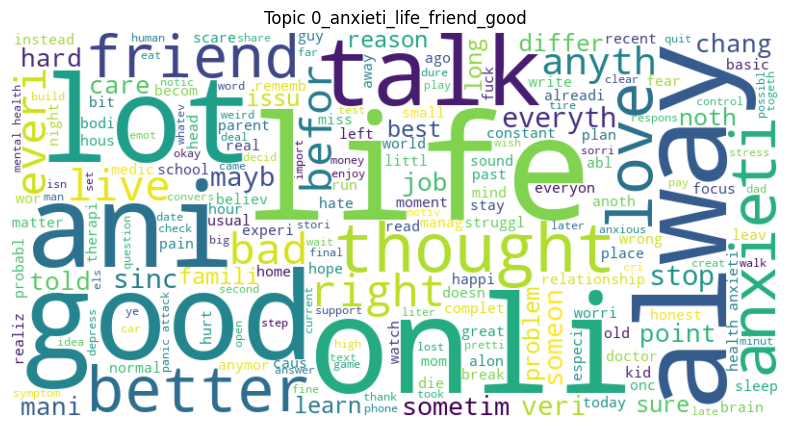

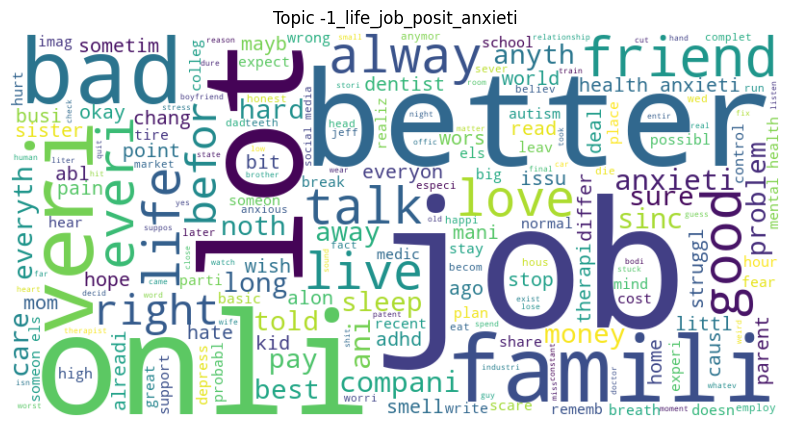

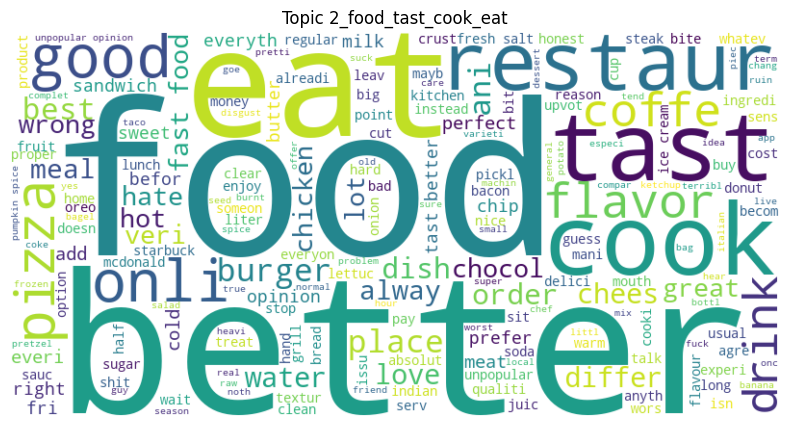

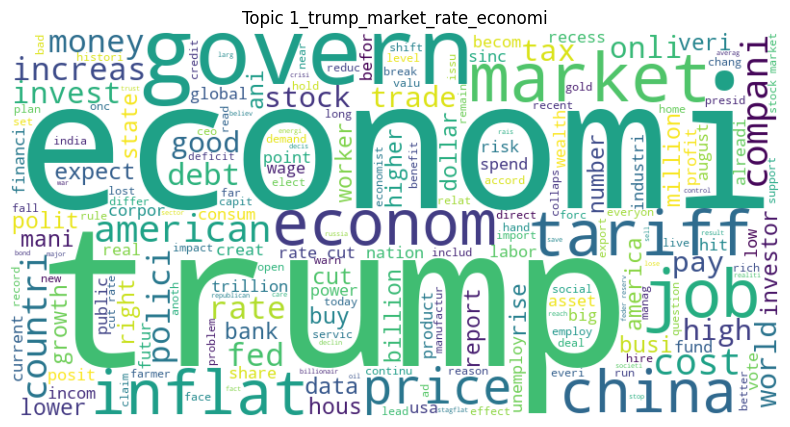

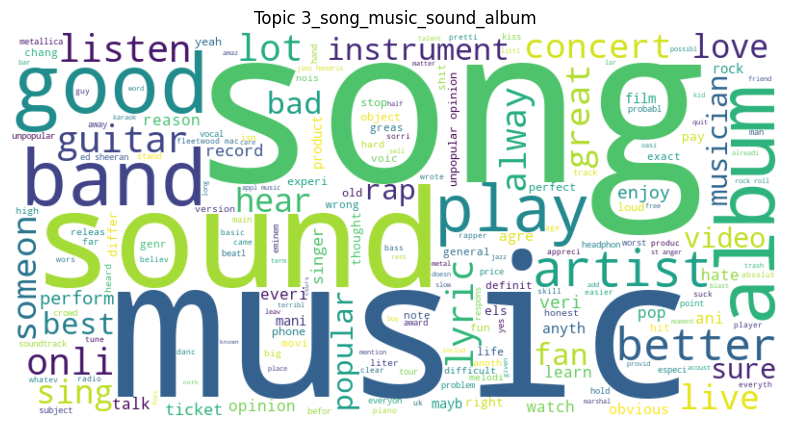

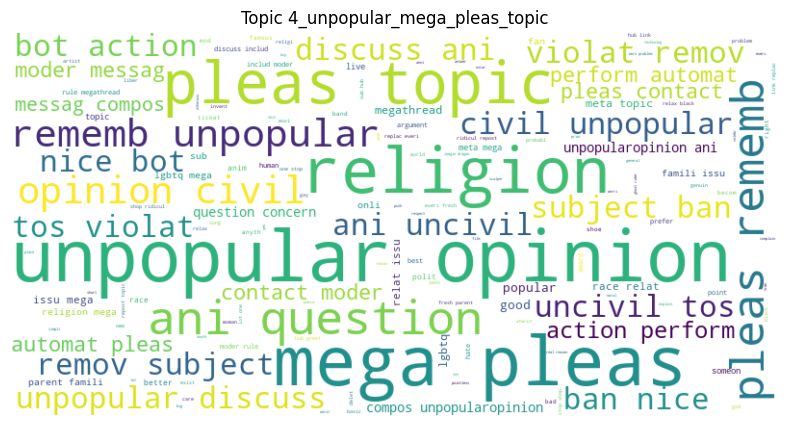

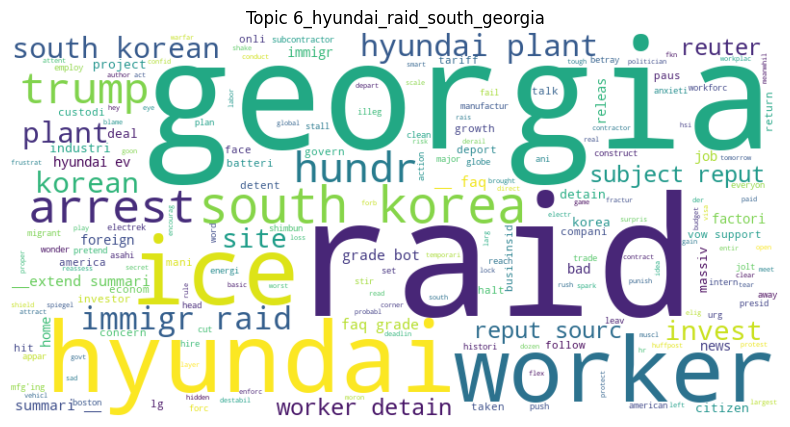

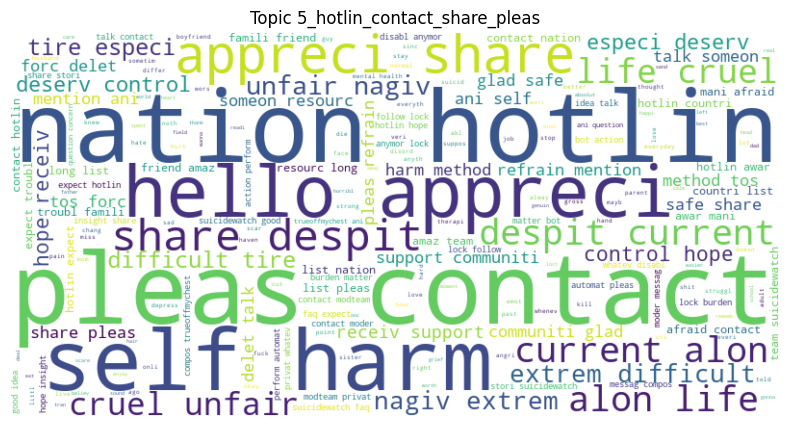

In [9]:
for topic in merged['Name'].unique():
    topic_docs = merged[merged['Name'] == topic]['text_all_processed']
    # Flatten list of tokens for all docs in this topic
    words = [word for tokens in topic_docs for word in tokens]
    text = ' '.join(words)
    if text.strip():  # Only plot if there are words
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Topic {topic}")
        plt.show()

### Key Findings
- Topics 0, −1, and 2 share several common high-frequency words such as *onli, better, and good*, meaning they are likely represent similar or overlapping themes. Their shared frequent words suggest the model may have split one broader theme into several smaller clusters.
- The remaining topics are more distinguishable, meaning those clusters capture more unique themes or user discussions.

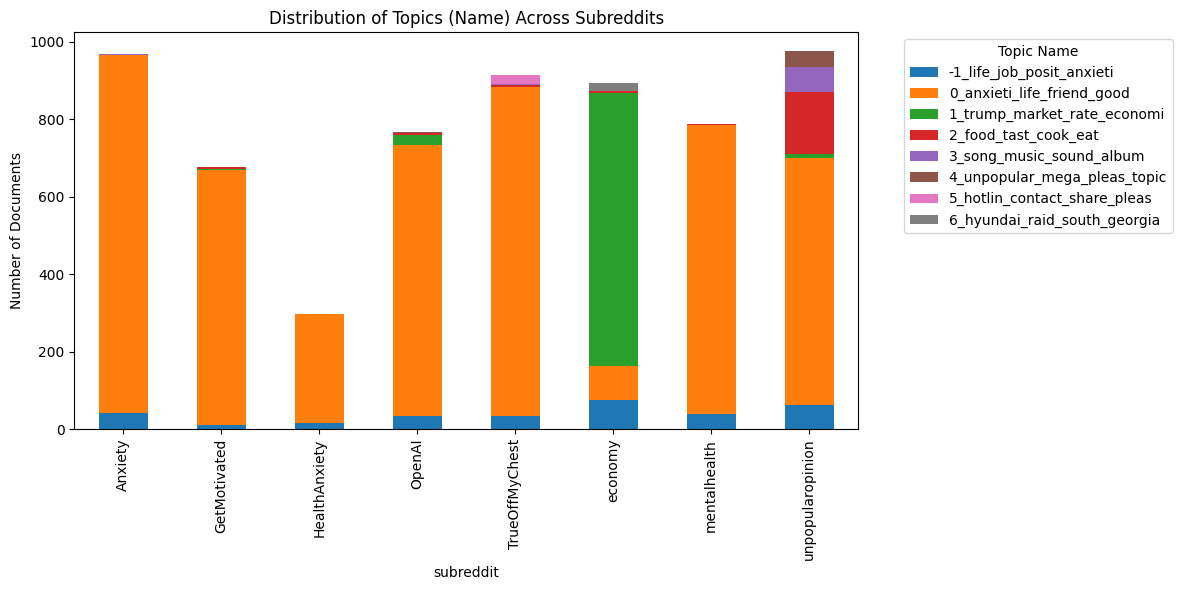

In [10]:
# Count the number of documents for each (subreddit, topic name) pair
topic_subreddit_counts = merged.groupby(['subreddit', 'Name']).size().unstack(fill_value=0)

# Plot as a stacked bar chart
ax = topic_subreddit_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_ylabel('Number of Documents')
ax.set_title('Distribution of Topics (Name) Across Subreddits')
ax.legend(title='Topic Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Key Findings 
- Topic 0 is widespread across all subreddits and accounts for a large proportion of the posts. This may be caused by bias in our subreddit selection that we intentionally included many anxiety-related communities, or it could indicate an issue with the model.
- The economy topic shows a high proportion of posts discussing Trump-market–related content, which suggests that the model can distinguish between different themes. Therefore, the large size of Topic 0 is more likely due to subreddit selection bias than a modeling problem.

[Next: Labeled Dataset Comparison →](05_dataset_comparison_analysis.ipynb)